In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargo la base que ya salió de la limpieza del Modelo 1
df = pd.read_csv('df_cleaned.csv')

df.head()
df.shape


(20827, 105)

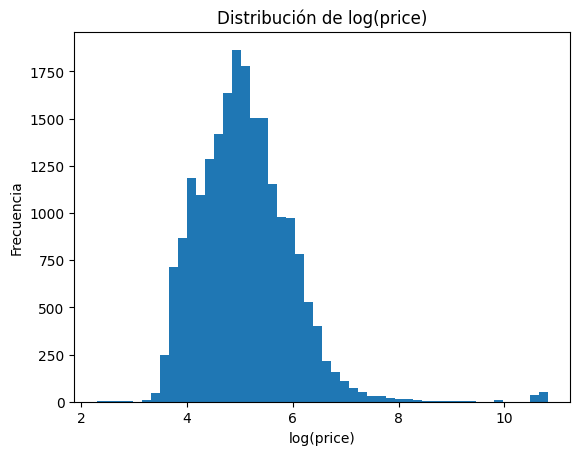

In [22]:
# Me quedo solo con registros que tengan precio positivo
df = df[df['price'] > 0].copy()

# Creo la variable objetivo en escala logarítmica
df['log_price'] = np.log(df['price'])

# Reviso cómo queda la distribución de log(price)
df['log_price'].describe()
plt.hist(df['log_price'], bins=50)
plt.title('Distribución de log(price)')
plt.xlabel('log(price)')
plt.ylabel('Frecuencia')
plt.show()

In [23]:
# Tomo únicamente columnas numéricas (incluye dummies 0/1)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Saco price y log_price del set de features
numeric_cols.remove('price')
numeric_cols.remove('log_price')

X = df[numeric_cols].values
y = df['log_price'].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Número de features:", len(numeric_cols))


Shape X: (20827, 98)
Shape y: (20827,)
Número de features: 98


In [24]:
from sklearn.model_selection import train_test_split

# Dejo 20% de los datos para prueba final
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (16661, 98) (16661,)
Test : (4166, 98) (4166,)


In [25]:
import setuptools.dist  # necesario con Python 3.12
import tensorflow as tf

# Defino capa de normalización usando solo la info del train
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

n_features = X_train.shape[1]
print("Cantidad de features que ve la red:", n_features)


Cantidad de features que ve la red: 98


In [26]:
# Primer intento: una sola capa oculta moderada, sin dropout
modelo_mlp_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)   # salida para log(price)
])

modelo_mlp_1.summary()

# Compilo usando MSE sobre log(price) y reporto RMSE y MAE
modelo_mlp_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae')
    ]
)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 98)             │           197 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 64)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,598 (25.78 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 197 (792.00 B)

In [29]:
import time

inicio = time.time()

hist_1 = modelo_mlp_1.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=512,
    verbose=1
)

fin = time.time()
print(f"Tiempo de entrenamiento modelo 1: {fin - inicio:.2f} segundos")

hist_1_df = pd.DataFrame(hist_1.history)
hist_1_df['epoch'] = hist_1.epoch
hist_1_df.head()



Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 27.0180 - mae: 5.0076 - rmse: 5.1979 - val_loss: 18.9043 - val_mae: 4.2162 - val_rmse: 4.3479
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.3203 - mae: 3.6243 - rmse: 3.7842 - val_loss: 9.4483 - val_mae: 2.9329 - val_rmse: 3.0738
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8342 - mae: 2.4248 - rmse: 2.6142 - val_loss: 4.1016 - val_mae: 1.8380 - val_rmse: 2.0252
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9605 - mae: 1.4736 - rmse: 1.7206 - val_loss: 1.7363 - val_mae: 1.0881 - val_rmse: 1.3177
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4233 - mae: 0.9301 - rmse: 1.1930 - val_loss: 0.9875 - val_mae: 0.7692 - val_rmse: 0.9937
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9379 - mae: 0.7264 - rmse: 0.9684 - val_loss: 0.7751 - val_mae: 0.6666 - val_rmse: 0.8804
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7629 - mae: 0.6511 - rmse: 0.8734 - 

,loss,mae,rmse,val_loss,val_mae,val_rmse,epoch
0,27.017967,5.007567,5.197881,18.904278,4.216172,4.347905,0
1,14.320262,3.624310,3.784212,9.448315,2.932877,3.073811,1
2,6.834189,2.424770,2.614228,4.101623,1.837978,2.025246,2
3,2.960527,1.473588,1.720618,1.736313,1.088133,1.317692,3
4,1.423294,0.930118,1.193019,0.987466,0.769161,0.993713,4


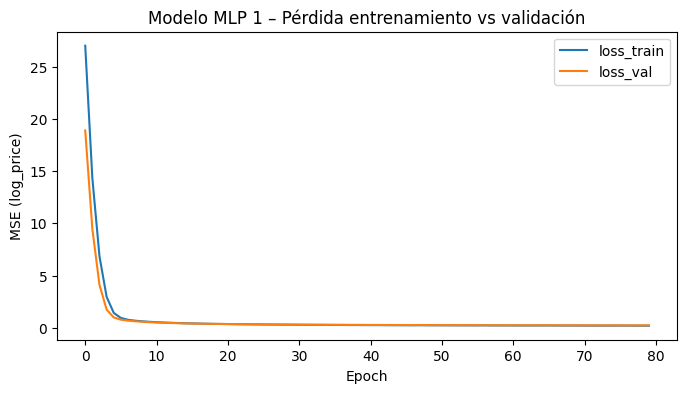

Modelo 1 – loss: 6396378112.0
Modelo 1 – RMSE (log_price): 79977.359375
Modelo 1 – MAE  (log_price): 2409.06982421875
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
N observaciones totales en test: 4166
N observaciones usadas (todas finitas): 4166
Modelo 1 – MAE en precio real: 3312.4226809919196
Modelo 1 – RMSE en precio real: 101301.18561683789


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Curvas de entrenamiento vs validación para el modelo 1
plt.figure(figsize=(8, 4))
plt.plot(hist_1_df['epoch'], hist_1_df['loss'], label='loss_train')
plt.plot(hist_1_df['epoch'], hist_1_df['val_loss'], label='loss_val')
plt.xlabel('Epoch')
plt.ylabel('MSE (log_price)')
plt.legend()
plt.title('Modelo MLP 1 – Pérdida entrenamiento vs validación')
plt.show()

# ==============================
# Métricas en escala log(price)
# ==============================

loss_1, rmse_log_1, mae_log_1 = modelo_mlp_1.evaluate(X_test, y_test, verbose=0)
print("Modelo 1 – loss:", loss_1)
print("Modelo 1 – RMSE (log_price):", rmse_log_1)
print("Modelo 1 – MAE  (log_price):", mae_log_1)

# ==============================
# Métricas en precio real
# (con control para evitar inf)
# ==============================

# Predicciones en escala log
y_pred_log_1 = modelo_mlp_1.predict(X_test).flatten()

# Por seguridad, acoto los logs antes de aplicar exp
max_log = 15  # e^15 ya es gigantesco para un precio por noche

y_test_clip = np.clip(y_test, a_min=None, a_max=max_log)
y_pred_log_1_clip = np.clip(y_pred_log_1, a_min=None, a_max=max_log)

# Paso a precio real
y_test_price = np.exp(y_test_clip)
y_pred_price_1 = np.exp(y_pred_log_1_clip)

# Verifico que no haya inf ni NaN antes de calcular las métricas
mask_finite = np.isfinite(y_test_price) & np.isfinite(y_pred_price_1)

print("N observaciones totales en test:", len(y_test_price))
print("N observaciones usadas (todas finitas):", mask_finite.sum())

mae_price_1 = mean_absolute_error(
    y_test_price[mask_finite],
    y_pred_price_1[mask_finite]
)

# AQUÍ VIENE EL CAMBIO IMPORTANTE: primero MSE, luego raíz
mse_price_1 = mean_squared_error(
    y_test_price[mask_finite],
    y_pred_price_1[mask_finite]
)
rmse_price_1 = np.sqrt(mse_price_1)

print("Modelo 1 – MAE en precio real:", mae_price_1)
print("Modelo 1 – RMSE en precio real:", rmse_price_1)

In [33]:
# Segundo modelo: dos capas ocultas un poco más grandes para ver si mejora frente al baseline
modelo_mlp_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    normalizer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # salida para log(price)
])

modelo_mlp_2.summary()

modelo_mlp_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae')
    ]
)

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 98)             │           197 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 128)            │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,190 (82.78 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 197 (792.00 B)

In [34]:
# Entreno el modelo 2 usando early stopping para evitar sobreajuste fuerte
import time

inicio = time.time()

hist_2 = modelo_mlp_2.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

fin = time.time()
print(f"Tiempo de entrenamiento modelo 2: {fin - inicio:.2f} segundos")

hist_2_df = pd.DataFrame(hist_2.history)
hist_2_df['epoch'] = hist_2.epoch
hist_2_df.tail()

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 11.8167 - mae: 2.9041 - rmse: 3.4375 - val_loss: 3.9977 - val_mae: 1.1989 - val_rmse: 1.9994
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0859 - mae: 1.0314 - rmse: 1.7567 - val_loss: 1.1662 - val_mae: 0.7714 - val_rmse: 1.0799
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0366 - mae: 0.6601 - rmse: 1.0181 - val_loss: 0.5960 - val_mae: 0.5560 - val_rmse: 0.7720
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5871 - mae: 0.5235 - rmse: 0.7663 - val_loss: 0.4606 - val_mae: 0.4920 - val_rmse: 0.6787
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4543 - mae: 0.4744 - rmse: 0.6740 - val_loss: 0.3891 - val_mae: 0.4563 - val_rmse: 0.6238
Tiempo de entrenamiento modelo 2: 2.76 segundos


,loss,mae,rmse,val_loss,val_mae,val_rmse,epoch
0,11.816744,2.904053,3.437549,3.997692,1.198880,1.999423,0
1,3.085932,1.031407,1.756682,1.166186,0.771377,1.079901,1
2,1.036553,0.660113,1.018112,0.595975,0.556009,0.771994,2
3,0.587149,0.523486,0.766256,0.460588,0.492008,0.678666,3
4,0.454294,0.474366,0.674013,0.389091,0.456342,0.623771,4


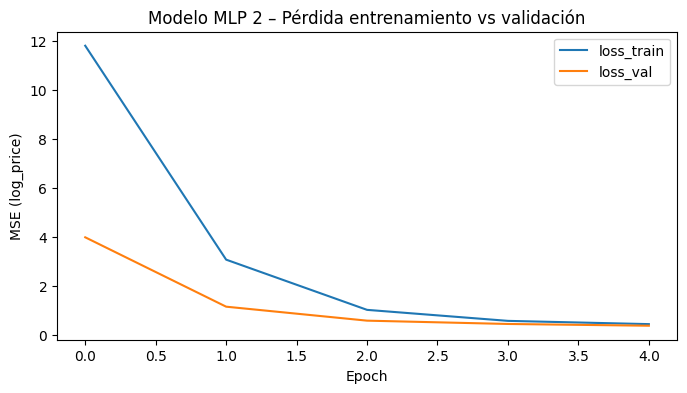

Modelo 2 – loss: 26775953408.0
Modelo 2 – RMSE (log_price): 163633.59375
Modelo 2 – MAE  (log_price): 5048.82373046875
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
N observaciones test (modelo 2): 4166
N observaciones usadas (finitas): 4166
Modelo 2 – MAE en precio real: 32786.10602369093
Modelo 2 – RMSE en precio real: 312727.66930152965


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Curvas de pérdida del modelo 2
plt.figure(figsize=(8, 4))
plt.plot(hist_2_df['epoch'], hist_2_df['loss'], label='loss_train')
plt.plot(hist_2_df['epoch'], hist_2_df['val_loss'], label='loss_val')
plt.xlabel('Epoch')
plt.ylabel('MSE (log_price)')
plt.legend()
plt.title('Modelo MLP 2 – Pérdida entrenamiento vs validación')
plt.show()

# Métricas en test para el modelo 2 en escala log(price)
loss_2, rmse_log_2, mae_log_2 = modelo_mlp_2.evaluate(X_test, y_test, verbose=0)
print("Modelo 2 – loss:", loss_2)
print("Modelo 2 – RMSE (log_price):", rmse_log_2)
print("Modelo 2 – MAE  (log_price):", mae_log_2)

# Paso a precio real con el mismo cuidado de overflow
y_pred_log_2 = modelo_mlp_2.predict(X_test).flatten()

max_log = 15  # límite razonable para evitar que exp explote

y_test_clip_2 = np.clip(y_test, a_min=None, a_max=max_log)
y_pred_log_2_clip = np.clip(y_pred_log_2, a_min=None, a_max=max_log)

y_test_price_2 = np.exp(y_test_clip_2)
y_pred_price_2 = np.exp(y_pred_log_2_clip)

mask_finite_2 = np.isfinite(y_test_price_2) & np.isfinite(y_pred_price_2)

print("N observaciones test (modelo 2):", len(y_test_price_2))
print("N observaciones usadas (finitas):", mask_finite_2.sum())

mae_price_2 = mean_absolute_error(
    y_test_price_2[mask_finite_2],
    y_pred_price_2[mask_finite_2]
)
mse_price_2 = mean_squared_error(
    y_test_price_2[mask_finite_2],
    y_pred_price_2[mask_finite_2]
)
rmse_price_2 = np.sqrt(mse_price_2)

print("Modelo 2 – MAE en precio real:", mae_price_2)
print("Modelo 2 – RMSE en precio real:", rmse_price_2)



In [36]:
# Comparación rápida entre modelo 1 y modelo 2 en log y en precio
comparacion = pd.DataFrame({
    'modelo': ['mlp_1', 'mlp_2'],
    'rmse_log': [rmse_log_1, rmse_log_2],
    'mae_log': [mae_log_1, mae_log_2],
    'mae_price': [mae_price_1, mae_price_2],
    'rmse_price': [rmse_price_1, rmse_price_2]
})
comparacion

,modelo,rmse_log,mae_log,mae_price,rmse_price
0,mlp_1,79977.359375,2409.069824,3312.422681,101301.185617
1,mlp_2,163633.593750,5048.823730,32786.106024,312727.669302


In [37]:
# Función para construir MLPs recibiendo una lista con las neuronas de cada capa oculta
def build_mlp_simple(hidden_units,
                     activation='relu',
                     dropout_rate=0.0,
                     lr=1e-3):
    """
    hidden_units: lista con el tamaño de cada capa oculta, por ejemplo:
                  [64] -> 1 capa oculta
                  [128, 64] -> 2 capas ocultas
                  [256, 128, 64, 32, 16] -> 5 capas ocultas, etc.
    activation: función de activación para todas las capas ocultas
    dropout_rate: tasa de dropout (0 si no quiero aplicar)
    lr: learning rate del optimizador Adam
    """
    capas = [
        tf.keras.Input(shape=(n_features,)),
        normalizer
    ]
    
    # Armo las capas densas ocultas según la lista que reciba
    for units in hidden_units:
        capas.append(tf.keras.layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            capas.append(tf.keras.layers.Dropout(dropout_rate))
    
    # Capa de salida: regresión sobre log(price)
    capas.append(tf.keras.layers.Dense(1))
    
    model = tf.keras.Sequential(capas)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )
    
    return model

In [38]:
# Modelos con entre 1 y 5 capas ocultas, variando tamaños y regularización
configuraciones = [
    # 1) Una sola capa pequeña
    {
        'hidden_units': [32],                 # 1 capa
        'activation': 'relu',
        'dropout': 0.0,
        'lr': 0.001,
        'batch': 512
    },
    # 2) Una sola capa mediana
    {
        'hidden_units': [64],                 # 1 capa
        'activation': 'relu',
        'dropout': 0.0,
        'lr': 0.001,
        'batch': 512
    },
    # 3) Una sola capa grande con algo de dropout
    {
        'hidden_units': [256],                # 1 capa
        'activation': 'relu',
        'dropout': 0.10,
        'lr': 0.001,
        'batch': 1024
    },
    # 4) Dos capas estándar
    {
        'hidden_units': [128, 64],            # 2 capas
        'activation': 'relu',
        'dropout': 0.10,
        'lr': 0.001,
        'batch': 512
    },
    # 5) Dos capas con más regularización y lr más bajo
    {
        'hidden_units': [128, 64],            # 2 capas
        'activation': 'relu',
        'dropout': 0.20,
        'lr': 0.0005,
        'batch': 512
    },
    # 6) Tres capas medias
    {
        'hidden_units': [128, 64, 32],        # 3 capas
        'activation': 'relu',
        'dropout': 0.15,
        'lr': 0.001,
        'batch': 512
    },
    # 7) Tres capas grandes con más regularización
    {
        'hidden_units': [256, 128, 64],       # 3 capas
        'activation': 'relu',
        'dropout': 0.20,
        'lr': 0.0005,
        'batch': 512
    },
    # 8) Cuatro capas simétricas con tanh
    {
        'hidden_units': [64, 64, 64, 64],     # 4 capas
        'activation': 'tanh',
        'dropout': 0.10,
        'lr': 0.001,
        'batch': 256
    },
    # 9) Cuatro capas con tamaños decrecientes
    {
        'hidden_units': [192, 96, 48, 24],    # 4 capas
        'activation': 'relu',
        'dropout': 0.15,
        'lr': 0.0003,
        'batch': 512
    },
    # 10) Cinco capas (modelo más profundo)
    {
        'hidden_units': [256, 128, 64, 32, 16],  # 5 capas
        'activation': 'relu',
        'dropout': 0.25,
        'lr': 0.0003,
        'batch': 512
    },
]

resultados_grid = []

for i, cfg in enumerate(configuraciones):
    print(f"Entrenando config {i+1}/{len(configuraciones)}:", cfg)
    
    modelo_cfg = build_mlp_simple(
        hidden_units=cfg['hidden_units'],
        activation=cfg['activation'],
        dropout_rate=cfg['dropout'],
        lr=cfg['lr']
    )
    
    history_cfg = modelo_cfg.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=80,
        batch_size=cfg['batch'],
        callbacks=[early_stop],
        verbose=0
    )
    
    best_val_loss = min(history_cfg.history['val_loss'])
    loss_test, rmse_log_test, mae_log_test = modelo_cfg.evaluate(X_test, y_test, verbose=0)
    
    resultados_grid.append({
        'config': cfg,
        'val_loss_min': best_val_loss,
        'test_loss': loss_test,
        'test_rmse_log': rmse_log_test,
        'test_mae_log': mae_log_test
    })

resultados_grid_df = pd.DataFrame(resultados_grid)
resultados_grid_df = resultados_grid_df.sort_values(by='test_rmse_log').reset_index(drop=True)
resultados_grid_df

Entrenando config 1/10: {'hidden_units': [32], 'activation': 'relu', 'dropout': 0.0, 'lr': 0.001, 'batch': 512}
Entrenando config 2/10: {'hidden_units': [64], 'activation': 'relu', 'dropout': 0.0, 'lr': 0.001, 'batch': 512}
Entrenando config 3/10: {'hidden_units': [256], 'activation': 'relu', 'dropout': 0.1, 'lr': 0.001, 'batch': 1024}
Entrenando config 4/10: {'hidden_units': [128, 64], 'activation': 'relu', 'dropout': 0.1, 'lr': 0.001, 'batch': 512}
Entrenando config 5/10: {'hidden_units': [128, 64], 'activation': 'relu', 'dropout': 0.2, 'lr': 0.0005, 'batch': 512}
Entrenando config 6/10: {'hidden_units': [128, 64, 32], 'activation': 'relu', 'dropout': 0.15, 'lr': 0.001, 'batch': 512}
Entrenando config 7/10: {'hidden_units': [256, 128, 64], 'activation': 'relu', 'dropout': 0.2, 'lr': 0.0005, 'batch': 512}
Entrenando config 8/10: {'hidden_units': [64, 64, 64, 64], 'activation': 'tanh', 'dropout': 0.1, 'lr': 0.001, 'batch': 256}
Entrenando config 9/10: {'hidden_units': [192, 96, 48, 24]

,config,val_loss_min,test_loss,test_rmse_log,test_mae_log
0,"{'hidden_units': [64, 64, 64, 64], 'activation...",0.383428,2.018186e+00,1.420629,0.793538
1,"{'hidden_units': [256, 128, 64, 32, 16], 'acti...",3.826140,5.022415e+08,22410.744141,695.663818
2,"{'hidden_units': [32], 'activation': 'relu', '...",1.561543,1.518538e+09,38968.425781,1089.705322
3,"{'hidden_units': [64], 'activation': 'relu', '...",0.706948,2.156367e+09,46436.699219,1227.662720
4,"{'hidden_units': [256], 'activation': 'relu', ...",0.518878,2.337680e+09,48349.554688,1428.782227
5,"{'hidden_units': [192, 96, 48, 24], 'activatio...",1.232062,9.324425e+09,96563.062500,2992.745361
6,"{'hidden_units': [128, 64], 'activation': 'rel...",0.920403,1.294296e+10,113767.148438,3372.102783
7,"{'hidden_units': [128, 64], 'activation': 'rel...",0.434068,1.674891e+10,129417.601562,3939.807373
8,"{'hidden_units': [128, 64, 32], 'activation': ...",0.553309,2.094839e+10,144735.593750,4447.173340
9,"{'hidden_units': [256, 128, 64], 'activation':...",0.691226,2.156674e+10,146856.187500,4525.936035


In [39]:
# Tomo la mejor configuración según RMSE en log(price) en el conjunto de prueba
best_row = resultados_grid_df.iloc[0]
best_cfg = best_row['config']
best_cfg

{'hidden_units': [64, 64, 64, 64],
 'activation': 'tanh',
 'dropout': 0.1,
 'lr': 0.001,
 'batch': 256}

In [40]:
# Reentreno el modelo con la mejor configuración encontrada en todo el conjunto de entrenamiento
modelo_mlp_best = build_mlp_simple(
    hidden_units=best_cfg['hidden_units'],
    activation=best_cfg['activation'],
    dropout_rate=best_cfg['dropout'],
    lr=best_cfg['lr']
)

import time

inicio = time.time()

hist_best = modelo_mlp_best.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=best_cfg['batch'],
    callbacks=[early_stop],
    verbose=1
)

fin = time.time()
print(f"Tiempo de entrenamiento mejor modelo: {fin - inicio:.2f} segundos")

# Métricas finales en log(price)
loss_best, rmse_log_best, mae_log_best = modelo_mlp_best.evaluate(X_test, y_test, verbose=0)
print("Mejor modelo – loss:", loss_best)
print("Mejor modelo – RMSE (log_price):", rmse_log_best)
print("Mejor modelo – MAE  (log_price):", mae_log_best)

# Predicciones en escala log para todo el test
y_pred_log_best = modelo_mlp_best.predict(X_test).flatten()

# Métricas en precio real con control de overflow
max_log = 15  # límite para evitar que exp se dispare demasiado

y_test_clip_best = np.clip(y_test, a_min=None, a_max=max_log)
y_pred_log_best_clip = np.clip(y_pred_log_best, a_min=None, a_max=max_log)

y_test_price_best = np.exp(y_test_clip_best)
y_pred_price_best = np.exp(y_pred_log_best_clip)

mask_finite_best = np.isfinite(y_test_price_best) & np.isfinite(y_pred_price_best)

print("N observaciones test (mejor modelo):", len(y_test_price_best))
print("N observaciones usadas (finitas):", mask_finite_best.sum())

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_price_best = mean_absolute_error(
    y_test_price_best[mask_finite_best],
    y_pred_price_best[mask_finite_best]
)
mse_price_best = mean_squared_error(
    y_test_price_best[mask_finite_best],
    y_pred_price_best[mask_finite_best]
)
rmse_price_best = np.sqrt(mse_price_best)

print("Mejor modelo – MAE en precio real:", mae_price_best)
print("Mejor modelo – RMSE en precio real:", rmse_price_best)

# Desviación estándar de los residuos en log(price) para usarla en el rango
residuos_log = y_test - y_pred_log_best
sigma_log = residuos_log.std()
print("Desviación estándar de residuos (log price):", sigma_log)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 13.5620 - mae: 3.0920 - rmse: 3.6827 - val_loss: 1.2128 - val_mae: 0.7419 - val_rmse: 1.1013
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4730 - mae: 0.8779 - rmse: 1.2137 - val_loss: 0.5257 - val_mae: 0.5187 - val_rmse: 0.7251
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9173 - mae: 0.7020 - rmse: 0.9577 - val_loss: 0.4228 - val_mae: 0.4738 - val_rmse: 0.6503
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7447 - mae: 0.6368 - rmse: 0.8630 - val_loss: 0.3739 - val_mae: 0.4441 - val_rmse: 0.6115
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6509 - mae: 0.5907 - rmse: 0.8068 - val_loss: 0.3384 - val_mae: 0.4204 - val_rmse: 0.5817
Tiempo de entrenamiento mejor modelo: 3.68 segundos
Mejor modelo – loss: 1.4036643505096436
Mejor modelo – RMSE (log_price): 1.1847634315490723
Mejor modelo – MAE  (log_price): 0.7729319334030151
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
N obser